# MSDS 7331 - Mini-Project: SVM&LR Classification
## Team: Dineen Parker, Dale Legband, Ryan Shuhart
collaboration site: https://github.com/rlshuhart/MSDS7331_Mini-Lab

### Log to capture iterations of findings and ideas for feature selection and analysis

1. First attempt of logistic model revealed need to one-hot encode categorical variables
2. After numerically encoding categorical variables, the logistic model more or less predicted all to not default.
3. Changeing penalty on logistic model from l2 to l1 improved the model by about 3 percentage points.
4. Changing class_weight='balanced' negatively impacted model
5. Changing C to 100 had no impact
6. Changing C to .0001 had small negative impact
7. Reviewed logistic coefficients on scaled data and it appears the most recent pay status (PAY_0_Sept), the most recent two bill amounts ('BILL_AMT1_Sept', 'BILL_AMT2_Aug'), the most recent two payment amounts are the highest predictors ('PAY_AMT1_Sept', 'PAY_AMT2_Aug').
8. Full SVM Model was stopped after not completing after 2 hours. SGD will be pursued instead.
9. SGD performed much faster, but not very accurate
9. Interpreted Logistic Model - only 4 variables worth keeping
10. Reduced logistic model performs about the same, but much simpler
11. SGD classifier is faster than logistic.
12. SVM on reduced model takes a long time and is less accurate on this data set and features.

## SVM and Logistic Regression Modeling  
* <font color = "black">[50 points] Create a logistic regression model and a support vector machine model for the classiﬁcation task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is ﬁne to use. </font>
* <font color = "black">[10 points] Discuss the advantages of each model for each classiﬁcation task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efﬁciency? Explain in detail.  
* <font color = "black">[30 points] Use the weights from logistic regression to interpret the importance of different features for each classiﬁcation task. Explain your interpretation in detail. Why do you think some variables are more important? </font>
* <font color = "black">[10 points] Look at the chosen support vectors for the classiﬁcation task. Do these provide any insight into the data? Explain

In [1]:
### Modules Used ###

# Data manipulation: pandas and numpy
import pandas as pd
import numpy as np

# Visualization: seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# other
import time
import warnings

# Read in preprocessed data from previous assignment

In [2]:
# Random but useful fact: if the first record in a csv file is 
# "ID" than Excel will interpret it as a SYLK file
# https://annalear.ca/2010/06/10/why-excel-thinks-your-csv-is-a-sylk/

#data_url = "https://raw.githubusercontent.com/rlshuhart/MSDS7331_Project_1/master/cc_data/cc_data_processed.csv"
data_url = "../MSDS7331_Project_1/cc_data/cc_data_processed.csv"

cc_data = pd.read_csv(data_url, index_col='ID')

In [3]:
print(cc_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 27 columns):
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null object
EDUCATION                     30000 non-null object
MARRIAGE                      30000 non-null object
AGE                           30000 non-null int64
PAY_0_Sept                    30000 non-null int64
PAY_2_Aug                     30000 non-null int64
PAY_3_July                    30000 non-null int64
PAY_4_June                    30000 non-null int64
PAY_5_May                     30000 non-null int64
PAY_6_April                   30000 non-null int64
BILL_AMT1_Sept                30000 non-null int64
BILL_AMT2_Aug                 30000 non-null int64
BILL_AMT3_July                30000 non-null int64
BILL_AMT4_June                30000 non-null int64
BILL_AMT5_May                 30000 non-null int64
BILL_AMT6_April               30000 non-null int64
PAY_AMT1_Sept        

# Additional Preprocessing of data

### One hot encoding of categorical variables

In [4]:
# makeing copy of data to retain original input for now. 
# Have to add .copy() or any change will reflect in the original too.
cc_data_processed = cc_data.copy()

cats = ['SEX', 'EDUCATION', 'MARRIAGE','AGE_range', 'LIMIT_BAL_range']

# SEX convert to isMale
cc_data_processed['isMale'] = cc_data['SEX']=='Male'

# Two options for Education: 
# If treating ordinal then keep single columnn but label in numerical order
# if nominal then create dummy variables.
# Trying ordinal first with 'Others' as the highest. Previous exploration
# showed this group have better rates of default which continued the trend
# of more education means less likely to default:
cc_data_processed['EDUCATION'] = cc_data['EDUCATION'].apply({'High School':0,
                                                             'University':1,
                                                             'Graduate School':2, 
                                                             'Others':3}.get)

# Marriage is nominal category therefore converting to dummies

cc_data_processed = pd.concat((cc_data_processed, 
                               pd.get_dummies(cc_data['MARRIAGE'], prefix='Marriage')), 
                               axis=1)

# Age range is ordinal category:
cc_data_processed['AGE_range'] = cc_data['AGE_range'].apply({'21-30':0,
                                                             '31-40':1,
                                                             '41-50':2, 
                                                             '51-60':3,
                                                             '61-70':4,
                                                             '71-80+':5}.get)
# Limit_Bal_Range is ordingal
cc_data_processed['LIMIT_BAL_range'] = cc_data['LIMIT_BAL_range'].apply({'0-250k':0,
                                                                         '>250k-500k':1,
                                                                         '>500k-750k':2,
                                                                         '>750k':3}.get)

# Drop unused features:
# 'Default_Yes_No' - Used for visualization labeling only and same as 'default payment next month'
# 'AGE' - Using Age_range instead, may bring back
cc_data_processed.drop(['Default_Yes_No','AGE', 'SEX','MARRIAGE', 'LIMIT_BAL'], axis=1, inplace=True)

print(cc_data_processed.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 26 columns):
EDUCATION                     30000 non-null int64
PAY_0_Sept                    30000 non-null int64
PAY_2_Aug                     30000 non-null int64
PAY_3_July                    30000 non-null int64
PAY_4_June                    30000 non-null int64
PAY_5_May                     30000 non-null int64
PAY_6_April                   30000 non-null int64
BILL_AMT1_Sept                30000 non-null int64
BILL_AMT2_Aug                 30000 non-null int64
BILL_AMT3_July                30000 non-null int64
BILL_AMT4_June                30000 non-null int64
BILL_AMT5_May                 30000 non-null int64
BILL_AMT6_April               30000 non-null int64
PAY_AMT1_Sept                 30000 non-null int64
PAY_AMT2_Aug                  30000 non-null int64
PAY_AMT3_July                 30000 non-null int64
PAY_AMT4_June                 30000 non-null int64
PAY_AMT5_May            

#### Convert data to numpy arrays for training

In [5]:
cc_data_target = cc_data_processed['default payment next month'].values
cc_data_Xs = cc_data_processed.drop('default payment next month', axis='columns').values

# Column names for labeling
cc_data_Xs_names = cc_data_processed.drop('default payment next month', axis='columns').columns

# Prediction Models

In [6]:
# Scikit Modules
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics as mt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn import grid_search

In [7]:
# Create Cross Validation object with an 80/20 split
num_cv_iterations = 5
num_instances = len(cc_data_target)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)

In [8]:
# Sample Default Rate
sample_d_rt = (1 - cc_data_target.sum() / len(cc_data_target))*100
print("The sample default rate is: %.1f%%"  % sample_d_rt)

# The sample default rate is the same as predicting all zeros (or no defaults)
all_zeros = np.zeros(len(cc_data_target))
all_zero_score = mt.accuracy_score(cc_data_target,all_zeros)*100
print("The models should have an accuracy better than predicting all non-defaults of %.1f%%"  % all_zero_score)

The sample default rate is: 77.9%
The models should have an accuracy better than predicting all non-defaults of 77.9%


## Logistic Regression

### Review of different parameters

In [9]:
def grid_searcher(X, y, model, params, cv_object):
    clf = grid_search.GridSearchCV(model, params, cv=cv_object,n_jobs=-1)
    clf.fit(X, y)
    return clf

In [10]:
# set parameters for grid search to test all the different combinations
c_values = [.1,1,10,100,1000]#np.arange(.01, .1, 0.01)
model = LogisticRegression()
params = {'penalty':('l1','l2'), 'C':c_values, 'class_weight':(None, 'balanced')}

#run search and return results
logit_clf = grid_searcher(cc_data_Xs, cc_data_target, model, params, cv_object)

#print(clf.grid_scores_ )
print("The best estimator: ",logit_clf.best_estimator_)
print("The best accuracy score is: ", logit_clf.best_score_)
print("The best parameters of model is: ",logit_clf.best_params_)

The best estimator:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
The best accuracy score is:  0.811733333333
The best parameters of model is:  {'penalty': 'l1', 'C': 0.1, 'class_weight': None}


### The grid search reveals 
Grid search reveals: Penalty - l1 was selected over l2, which means that the objective function that is minimized is better for L1, which is the sum of errors, rather than L2, which is the sum of squared errors. L1 is less sensitive to outliers. The C=10 value indicates a larger value is needed for regularization which improves the models ability to not fit to noise. Class_weight selection of None over balanced means balanced did not add accuracy to the fit, likely because 'balanced' mode "uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data" The best accuracy score is 0.812 is just slightly better accuracy than predicting all non-defaults of 77.9%.

### Find coefficients 

In [11]:
def full_classify(X, y, cv_object, model, scale=False):
    start = time.time()
    # Create empty list to append coefficient results
    coef_list = []
    acc_list = []
    for iter_num, (train_indices, test_indices) in enumerate(cv_object):
        print("====Iteration",iter_num," ====")
        if scale == True:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                scl_obj = StandardScaler()
                scl_obj.fit(X[train_indices])
                X_train_scaled = scl_obj.transform(X[train_indices])
                X_test_scaled = scl_obj.transform(X[test_indices])
                model.fit(X_train_scaled,y[train_indices])
                y_hat = model.predict(X_test_scaled)
                print("\n*SCALED DATA*")
        elif scale == False:
            model.fit(X[train_indices],y[train_indices])  # train object
            y_hat = model.predict(X[test_indices]) # get test set precitions
        
        # append coefficients from model to list
        coef_list.append(model.coef_)
        acc_list.append(mt.accuracy_score(y[test_indices],y_hat))

        # print the accuracy and confusion matrix 
        #print("====Iteration",iter_num," ====")
        print("accuracy", mt.accuracy_score(y[test_indices],y_hat))
        print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))
        #print("Classification Report:\n",mt.classification_report(y[test_indices],y_hat))
        #print("ROC Score \n",mt.roc_auc_score(y[test_indices],y_hat))
        print()
        
    print('done. It took', time.time()-start, 'seconds.')    
    return coef_list, acc_list

In [12]:
### Run best model from grid search to get the coefficients from scaled data for interpretation
logit_coef_scaled, logit_acc_scaled = full_classify(cc_data_Xs, cc_data_target, cv_object, logit_clf.best_estimator_, scale=True)

====Iteration 0  ====

*SCALED DATA*
accuracy 0.808666666667
confusion matrix
 [[4532  140]
 [1008  320]]

====Iteration 1  ====

*SCALED DATA*
accuracy 0.805833333333
confusion matrix
 [[4511  110]
 [1055  324]]

====Iteration 2  ====

*SCALED DATA*
accuracy 0.812
confusion matrix
 [[4547  138]
 [ 990  325]]

====Iteration 3  ====

*SCALED DATA*
accuracy 0.812833333333
confusion matrix
 [[4567  118]
 [1005  310]]

====Iteration 4  ====

*SCALED DATA*
accuracy 0.814
confusion matrix
 [[4561  107]
 [1009  323]]

done. It took 2.857163429260254 seconds.


### Intrepretting weights of Logistic Model using Scaled Data

In [13]:
# Graph the coeficients to find the standout features
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def analysis(coef_list, acc_list, labels):
    # Below averages the output of the cross validations
    coef_list_avg = np.array(np.mean(coef_list, axis=0 ))
    acc_list_avg = np.mean(acc_list)

    print("The average accuracy score is: ", acc_list_avg)

    # Sanity check to make sure the column name list is the same length as the coefficients
    print("Coefficients and column names same length: " + str(len(coef_list_avg.T)==len(labels)))
    print()

    # print coefficients with label
    zip_vars = zip(coef_list_avg.T,labels) # combine attributes
    for coef, name in zip_vars:
        print(name, 'has weight of', coef[0]) # now print them out

    weights = pd.Series(coef_list_avg[0],index=labels)
    weights.plot(kind='bar')
    plt.show()

The average accuracy score is:  0.810666666667
Coefficients and column names same length: True

EDUCATION has weight of 0.00127101481712
PAY_0_Sept has weight of 0.656006998319
PAY_2_Aug has weight of 0.090142475061
PAY_3_July has weight of 0.101983491891
PAY_4_June has weight of 0.0206858092287
PAY_5_May has weight of 0.0411665800027
PAY_6_April has weight of 0.0130628559163
BILL_AMT1_Sept has weight of -0.236430773822
BILL_AMT2_Aug has weight of 0.0336423494592
BILL_AMT3_July has weight of 0.0167344273628
BILL_AMT4_June has weight of 0.0077491685575
BILL_AMT5_May has weight of 0.0336176241037
BILL_AMT6_April has weight of 0.0258620361634
PAY_AMT1_Sept has weight of -0.192756409776
PAY_AMT2_Aug has weight of -0.195983186064
PAY_AMT3_July has weight of -0.0569087797572
PAY_AMT4_June has weight of -0.069054756594
PAY_AMT5_May has weight of -0.0518092743884
PAY_AMT6_April has weight of -0.0443114200274
AGE_range has weight of 0.0390497909073
LIMIT_BAL_range has weight of -0.0293578831121

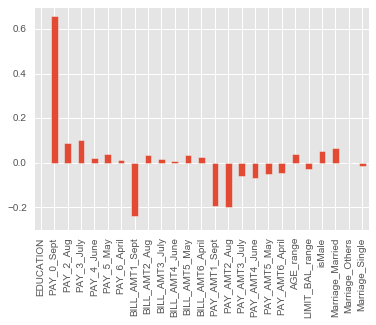

In [14]:
analysis(logit_coef_scaled, logit_acc_scaled, cc_data_Xs_names)

### Logitic Interpretation of Full Model

PAY_0_Sept and BILL_AMT1_Sept are the two strongest indicators of default. Pay_0_Sept and Bill_AMT1_Sept have high weights, >0.4 and <-0.4 respectively, compared to the other coefficients and are significant to the model. Secondarily, PAY_AMT1_Sept and PAY_AMT2_Aug have a similar strength of indicators. PAY_0_Sept indicates how many months late is the payment, so it is logical that as this increases the log odd of default would increase as well. BILL_AMT1 indicates the amount billed, and the weighting suggest counter to logic that bigger bills tended to default less frequently. Due to the high multicollinearity of the BILL_AMT variables, as discovered previously in project 1, this weighting might not be trustable. PAY_AMT1_Sept and PAY_AMT2_Aug have a negative weighting, suggesting as pay amounts decrease during these months, default goes higher.

### Reduced Logistic Model

In [15]:
logit_reduced_model = ['PAY_0_Sept',
                       'BILL_AMT1_Sept',
                       'PAY_AMT1_Sept',
                       'PAY_AMT2_Aug']

cc_data_Xs_logit_reduced = cc_data_processed[logit_reduced_model].values

# Column names for labeling
cc_data_Xs_names_lr = cc_data_processed[logit_reduced_model].columns

In [16]:
logit_coef_scaled_lr, logit_acc_scaled_lr = full_classify(cc_data_Xs_logit_reduced, cc_data_target,  cv_object, 
                                                          logit_clf.best_estimator_, scale=True)

====Iteration 0  ====

*SCALED DATA*
accuracy 0.816
confusion matrix
 [[4565  133]
 [ 971  331]]

====Iteration 1  ====

*SCALED DATA*
accuracy 0.811
confusion matrix
 [[4527  141]
 [ 993  339]]

====Iteration 2  ====

*SCALED DATA*
accuracy 0.811666666667
confusion matrix
 [[4526  147]
 [ 983  344]]

====Iteration 3  ====

*SCALED DATA*
accuracy 0.813
confusion matrix
 [[4523  143]
 [ 979  355]]

====Iteration 4  ====

*SCALED DATA*
accuracy 0.812666666667
confusion matrix
 [[4511  158]
 [ 966  365]]

done. It took 0.1540086269378662 seconds.


The average accuracy score is:  0.812866666667
Coefficients and column names same length: True

PAY_0_Sept has weight of 0.799649432448
BILL_AMT1_Sept has weight of -0.120387875182
PAY_AMT1_Sept has weight of -0.214566234272
PAY_AMT2_Aug has weight of -0.268160218783


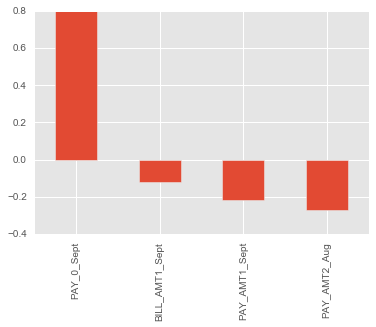

In [17]:
analysis(logit_coef_scaled_lr, logit_acc_scaled_lr, cc_data_Xs_names_lr)

### Comparison of Full Model to Reduced Model

The reduced model supports the analysis of the full model variable determined to be unecessary. The full model accuracy was 81.1% compared to the reduced model of 81.3%. Both the full and reduced model perform slightly better the an all no-default prediction of 77.9%. PAY_0_Sept increased from .66 to .80 and strengthened in the reduced model. BILL_AMT1_Sept reduced to -.13 making it less strong of a predictor. PAY_AMT1_Sept and PAY_AMT2_Aug slightly increase.

    Full:
    PAY_0_Sept has weight of 0.656006998319
    BILL_AMT1_Sept has weight of -0.236430773822
    PAY_AMT1_Sept has weight of -0.192756409776
    PAY_AMT2_Aug has weight of -0.195983186064

    Reduced:
    PAY_0_Sept has weight of 0.799649432448
    BILL_AMT1_Sept has weight of -0.120387875182
    PAY_AMT1_Sept has weight of -0.214566234272
    PAY_AMT2_Aug has weight of -0.268160218783

## Support Vector Machine - Using SGDClassifier

In [37]:
# Create New Cross Validation object
svg_cv_object = ShuffleSplit(n=len(cc_data_target), n_iter=10, test_size  = 0.2)

# Initial fixed parmeters
model = SGDClassifier(loss='hinge', n_iter=3, learning_rate='optimal')

# Parameteres to search on:
params = {'penalty':('l1','l2'),
          'fit_intercept':(True, False),
          'average':(True,False),
          'alpha':[.000001, .00001, .0001]} 
          #'alpha':np.arange(.00001, .001, 0.00005)}

# Run grid search with cv_object
sgd_clf = grid_searcher(cc_data_Xs, cc_data_target, model, params, svg_cv_object)

# Print grid serach results
print("The best estimator: ",sgd_clf.best_estimator_)
print("The best accuracy score is: ", sgd_clf.best_score_)
print("The best parameters of model is: ",sgd_clf.best_params_)

The best estimator:  SGDClassifier(alpha=1e-06, average=True, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=3, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
The best accuracy score is:  0.780133333333
The best parameters of model is:  {'alpha': 1e-06, 'fit_intercept': True, 'penalty': 'l2', 'average': True}


In [38]:
### Run best model from grid search to get the coefficients from scaled data for interpretation
sgd_coef_scaled, sgd_acc_scaled = full_classify(cc_data_Xs, cc_data_target, cv_object, sgd_clf.best_estimator_, scale=True)

====Iteration 0  ====

*SCALED DATA*
accuracy 0.806333333333
confusion matrix
 [[4450  225]
 [ 937  388]]

====Iteration 1  ====

*SCALED DATA*
accuracy 0.806333333333
confusion matrix
 [[4395  235]
 [ 927  443]]

====Iteration 2  ====

*SCALED DATA*
accuracy 0.812
confusion matrix
 [[4484  220]
 [ 908  388]]

====Iteration 3  ====

*SCALED DATA*
accuracy 0.811333333333
confusion matrix
 [[4465  223]
 [ 909  403]]

====Iteration 4  ====

*SCALED DATA*
accuracy 0.802666666667
confusion matrix
 [[4402  234]
 [ 950  414]]

done. It took 1.784101963043213 seconds.


The average accuracy score is:  0.807733333333
Coefficients and column names same length: True

EDUCATION has weight of 1.3637476358
PAY_0_Sept has weight of 70.1573876179
PAY_2_Aug has weight of 12.4808489751
PAY_3_July has weight of 12.3307913654
PAY_4_June has weight of 8.89432232424
PAY_5_May has weight of 11.8981773732
PAY_6_April has weight of 7.19245212492
BILL_AMT1_Sept has weight of -51.5475357536
BILL_AMT2_Aug has weight of 19.645623181
BILL_AMT3_July has weight of 10.068744218
BILL_AMT4_June has weight of 1.72068596744
BILL_AMT5_May has weight of -0.784179099636
BILL_AMT6_April has weight of -2.88019888936
PAY_AMT1_Sept has weight of -78.8294175431
PAY_AMT2_Aug has weight of -82.3951555225
PAY_AMT3_July has weight of -47.8878014255
PAY_AMT4_June has weight of -53.7945345564
PAY_AMT5_May has weight of -49.145122637
PAY_AMT6_April has weight of -40.5596426255
AGE_range has weight of -0.325980888484
LIMIT_BAL_range has weight of -14.9249849594
isMale has weight of 3.79892518675

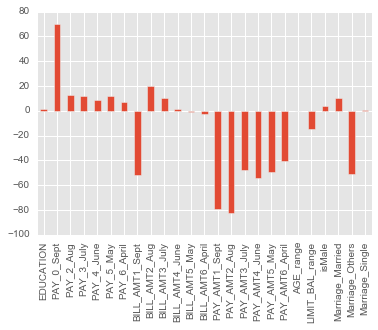

In [39]:
analysis(sgd_coef_scaled, sgd_acc_scaled, cc_data_Xs_names)

### SGD Full Model Interpretation

Like the previous logistic model, 'PAY_0_Sept', 'BILL_AMT1_Sept', 'PAY_AMT1_Sept', and 'PAY_AMT2_Aug' are important predictors to default. Also evident is the multicollinearity BILL_AMT features, with BILL_AMT1 showing the strongest predictor and BILL_AMT2 - BILL_AMT6 not at all. 'PAY_AMT1_Sept' and 'PAY_AMT2_Aug' also standout as the strongest.

### SGD Reduced Model

In [40]:
svg_reduced_model = ['PAY_0_Sept',
                     'BILL_AMT1_Sept',
                     'PAY_AMT1_Sept',
                     'PAY_AMT2_Aug']

cc_data_Xs_svg_reduced = cc_data_processed[svg_reduced_model].values

# Column names for labeling
cc_data_Xs_names_sr = cc_data_processed[svg_reduced_model].columns

In [41]:
sgd_coef_scaled_sr, sgd_acc_scaled_sr = full_classify(cc_data_Xs_svg_reduced, cc_data_target, cv_object, 
                                                sgd_clf.best_estimator_, scale=True)

====Iteration 0  ====

*SCALED DATA*
accuracy 0.799333333333
confusion matrix
 [[4327  348]
 [ 856  469]]

====Iteration 1  ====

*SCALED DATA*
accuracy 0.792
confusion matrix
 [[4280  385]
 [ 863  472]]

====Iteration 2  ====

*SCALED DATA*
accuracy 0.800666666667
confusion matrix
 [[4354  316]
 [ 880  450]]

====Iteration 3  ====

*SCALED DATA*
accuracy 0.801
confusion matrix
 [[4330  367]
 [ 827  476]]

====Iteration 4  ====

*SCALED DATA*
accuracy 0.792
confusion matrix
 [[4282  386]
 [ 862  470]]

done. It took 0.12000679969787598 seconds.


The average accuracy score is:  0.797
Coefficients and column names same length: True

PAY_0_Sept has weight of 15.8753954969
BILL_AMT1_Sept has weight of -1.56733822727
PAY_AMT1_Sept has weight of -36.7836747924
PAY_AMT2_Aug has weight of -43.7490685441


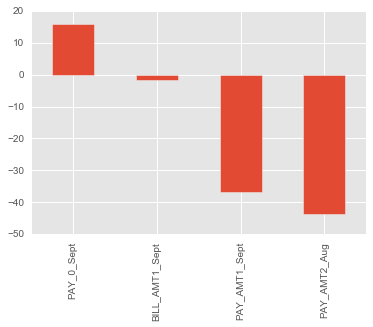

In [42]:
analysis(sgd_coef_scaled_sr, sgd_acc_scaled_sr, cc_data_Xs_names_sr)

#### Reduced Model Analysis
Compared to the full SGD model the reduced model has an average accuracy of 79.7% compared to 80.8%, which is not much more than an all no-default prediction of 77.9%. On this given data set and features the SGD performs slightly worse compared to the logistic regression model. The weight of PAY_0_Sept drops dramatically in this model and is not near as significant. As with the reduced logistic model BILL_AMT1_Sept no longer appears significant. PAY_AMT1_Sept and PAY_AMT2_Aug have the strongest weights that have meaning as these go up, the probability of default goes down.
    
    Full:
    PAY_0_Sept has weight of 70.1573876179
    BILL_AMT1_Sept has weight of -51.5475357536
    PAY_AMT1_Sept has weight of -78.8294175431
    PAY_AMT2_Aug has weight of -82.3951555225

    Reduced:
    PAY_0_Sept has weight of 15.8753954969
    BILL_AMT1_Sept has weight of -1.56733822727
    PAY_AMT1_Sept has weight of -36.7836747924
    PAY_AMT2_Aug has weight of -43.7490685441

### Reduced Model Using SVC

In [43]:
model = SVC(kernel='linear', C=1)
svc_coef_scaled_r, svc_acc_scaled_r = full_classify(cc_data_Xs_svg_reduced, cc_data_target, cv_object, 
                                                         model, scale=True)

====Iteration 0  ====

*SCALED DATA*
accuracy 0.7895
confusion matrix
 [[4737    0]
 [1263    0]]

====Iteration 1  ====

*SCALED DATA*
accuracy 0.775666666667
confusion matrix
 [[4654    0]
 [1346    0]]

====Iteration 2  ====

*SCALED DATA*
accuracy 0.773333333333
confusion matrix
 [[4640    0]
 [1360    0]]

====Iteration 3  ====

*SCALED DATA*
accuracy 0.783166666667
confusion matrix
 [[4699    0]
 [1301    0]]

====Iteration 4  ====

*SCALED DATA*
accuracy 0.779333333333
confusion matrix
 [[4676    0]
 [1324    0]]

done. It took 56.00320315361023 seconds.


The average accuracy score is:  0.7802
Coefficients and column names same length: True

PAY_0_Sept has weight of 0.000312843579196
BILL_AMT1_Sept has weight of -1.63712284898e-05
PAY_AMT1_Sept has weight of -1.9640661889e-05
PAY_AMT2_Aug has weight of -1.30706062819e-05


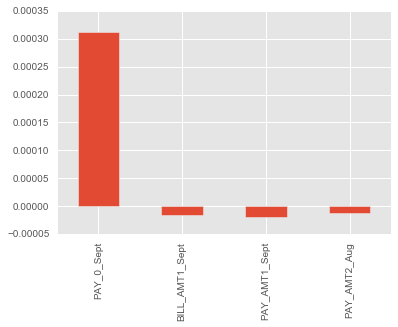

In [44]:
analysis(svc_coef_scaled_r, svc_acc_scaled_r, cc_data_Xs_names_sr)

# Comparison of Logistic Regression and SGD/SVC

Logistic regression has an advantage of accuracy and easier interpretation, but the performance is slower than SGD. The cross validation for Logistict regression took about 5 seconds, whereas, SGD took less than 2 seconds. The SGD classifier performance was about the same in terms of the average accuracy. On the other hand, the SVC classifier took so long, it was never completed and stopped after 2 hours. The SVC model on the reduce feature set as determined by the SGD classifier, took 51 seconds to complete the cross validation and showed it predicted only the 'no default' class. Perhaps further feature engineering could give SVC better performance.